# Scale-Free Networks: The Barabási-Albert Model

## Introduction

Scale-free networks are a class of complex networks characterized by a power-law degree distribution. Unlike random graphs (Erdős-Rényi) where node degrees follow a Poisson distribution, scale-free networks exhibit **preferential attachment**: highly connected nodes ("hubs") are more likely to receive new connections.

The **Barabási-Albert (BA) model**, introduced by Albert-László Barabási and Réka Albert in 1999, provides a generative mechanism for scale-free networks through two key principles:

1. **Growth**: The network expands by adding new nodes over time
2. **Preferential Attachment**: New nodes connect preferentially to existing nodes with high degree

## Mathematical Framework

### Preferential Attachment Probability

When a new node joins the network, it connects to $m$ existing nodes. The probability $\Pi(k_i)$ that the new node connects to an existing node $i$ with degree $k_i$ is:

$$\Pi(k_i) = \frac{k_i}{\sum_j k_j}$$

This means nodes with higher degree have a higher probability of receiving new connections—the "rich get richer" phenomenon.

### Degree Distribution

The BA model produces a power-law degree distribution:

$$P(k) \sim k^{-\gamma}$$

where the exponent $\gamma = 3$ for the standard BA model. This can be derived using a continuum approach.

### Continuum Theory

Let $k_i(t)$ denote the degree of node $i$ at time $t$. The rate of change is:

$$\frac{\partial k_i}{\partial t} = m \cdot \Pi(k_i) = m \cdot \frac{k_i}{\sum_j k_j} = \frac{k_i}{2t}$$

Since at time $t$, the total degree is $\sum_j k_j = 2mt$ (each new node adds $m$ edges, contributing $2m$ to total degree).

Solving this differential equation with initial condition $k_i(t_i) = m$ (node $i$ arrives at time $t_i$):

$$k_i(t) = m \left(\frac{t}{t_i}\right)^{1/2}$$

The probability that a node has degree smaller than $k$ is:

$$P(k_i(t) < k) = P\left(t_i > \frac{m^2 t}{k^2}\right) = 1 - \frac{m^2 t}{k^2} \cdot \frac{1}{t} = 1 - \frac{m^2}{k^2}$$

Taking the derivative gives the degree distribution:

$$P(k) = \frac{\partial P(k_i < k)}{\partial k} = \frac{2m^2}{k^3} \propto k^{-3}$$

Thus, $\gamma = 3$.

### Mean Degree and Network Properties

The mean degree $\langle k \rangle$ approaches:

$$\langle k \rangle = 2m$$

as the network grows large, since each new node contributes $m$ edges.

## Implementation

We will implement the Barabási-Albert model from scratch and analyze the resulting network properties.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
def barabasi_albert_graph(n, m):
    """
    Generate a Barabási-Albert scale-free network.
    
    Parameters:
    -----------
    n : int
        Total number of nodes in the final network
    m : int
        Number of edges each new node creates (must be <= initial nodes)
    
    Returns:
    --------
    edges : list of tuples
        List of (i, j) edges
    degrees : dict
        Degree of each node
    """
    if m < 1 or m >= n:
        raise ValueError("m must be >= 1 and < n")
    
    # Start with a complete graph of m+1 nodes
    edges = []
    degrees = {i: 0 for i in range(n)}
    
    # Initialize with complete graph on first m+1 nodes
    for i in range(m + 1):
        for j in range(i + 1, m + 1):
            edges.append((i, j))
            degrees[i] += 1
            degrees[j] += 1
    
    # List for preferential attachment sampling
    # Each node appears in this list once per edge it has
    repeated_nodes = []
    for i in range(m + 1):
        repeated_nodes.extend([i] * degrees[i])
    
    # Add remaining nodes one at a time
    for new_node in range(m + 1, n):
        # Select m unique targets using preferential attachment
        targets = set()
        while len(targets) < m:
            # Sample from repeated_nodes (preferential attachment)
            target = repeated_nodes[np.random.randint(len(repeated_nodes))]
            targets.add(target)
        
        # Add edges to selected targets
        for target in targets:
            edges.append((new_node, target))
            degrees[new_node] += 1
            degrees[target] += 1
            # Update repeated_nodes list
            repeated_nodes.append(new_node)
            repeated_nodes.append(target)
    
    return edges, degrees

In [3]:
# Generate a BA network
N = 10000  # Number of nodes
M = 3      # Edges per new node

print(f"Generating Barabási-Albert network with N={N}, m={M}...")
edges, degrees = barabasi_albert_graph(N, M)

# Basic statistics
num_edges = len(edges)
degree_values = list(degrees.values())
mean_degree = np.mean(degree_values)
max_degree = max(degree_values)

print(f"\nNetwork Statistics:")
print(f"  Nodes: {N}")
print(f"  Edges: {num_edges}")
print(f"  Mean degree: {mean_degree:.2f} (theoretical: {2*M})")
print(f"  Max degree: {max_degree}")

Generating Barabási-Albert network with N=10000, m=3...

Network Statistics:
  Nodes: 10000
  Edges: 29994
  Mean degree: 6.00 (theoretical: 6)
  Max degree: 308


## Degree Distribution Analysis

We now analyze the degree distribution to verify the power-law behavior with exponent $\gamma \approx 3$.

In [4]:
def compute_degree_distribution(degrees):
    """
    Compute the degree distribution P(k).
    
    Parameters:
    -----------
    degrees : dict
        Dictionary mapping node -> degree
    
    Returns:
    --------
    k_values : array
        Unique degree values
    p_k : array
        Probability P(k) for each degree
    """
    degree_counts = Counter(degrees.values())
    total_nodes = len(degrees)
    
    k_values = np.array(sorted(degree_counts.keys()))
    p_k = np.array([degree_counts[k] / total_nodes for k in k_values])
    
    return k_values, p_k

In [5]:
# Compute degree distribution
k_values, p_k = compute_degree_distribution(degrees)

# Filter for positive values (needed for log-log plot)
mask = (k_values > 0) & (p_k > 0)
k_plot = k_values[mask]
p_plot = p_k[mask]

In [6]:
def fit_power_law(k, p_k, k_min=5):
    """
    Fit a power law P(k) ~ k^(-gamma) using linear regression in log-log space.
    
    Parameters:
    -----------
    k : array
        Degree values
    p_k : array
        Corresponding probabilities
    k_min : int
        Minimum degree to include in fit (to avoid finite-size effects)
    
    Returns:
    --------
    gamma : float
        Fitted exponent
    intercept : float
        Fitted intercept (log of prefactor)
    """
    # Filter data
    mask = k >= k_min
    log_k = np.log10(k[mask])
    log_p = np.log10(p_k[mask])
    
    # Linear regression: log(P) = -gamma * log(k) + C
    coeffs = np.polyfit(log_k, log_p, 1)
    gamma = -coeffs[0]
    intercept = coeffs[1]
    
    return gamma, intercept

# Fit power law
gamma_fit, intercept = fit_power_law(k_plot, p_plot, k_min=5)
print(f"Fitted power-law exponent: γ = {gamma_fit:.3f}")
print(f"Theoretical value: γ = 3.000")

Fitted power-law exponent: γ = 1.857
Theoretical value: γ = 3.000


## Visualization

We create a comprehensive visualization showing:
1. The degree distribution on log-log scale with the theoretical power-law fit
2. Cumulative degree distribution
3. Histogram of degrees


Figure saved to 'plot.png'


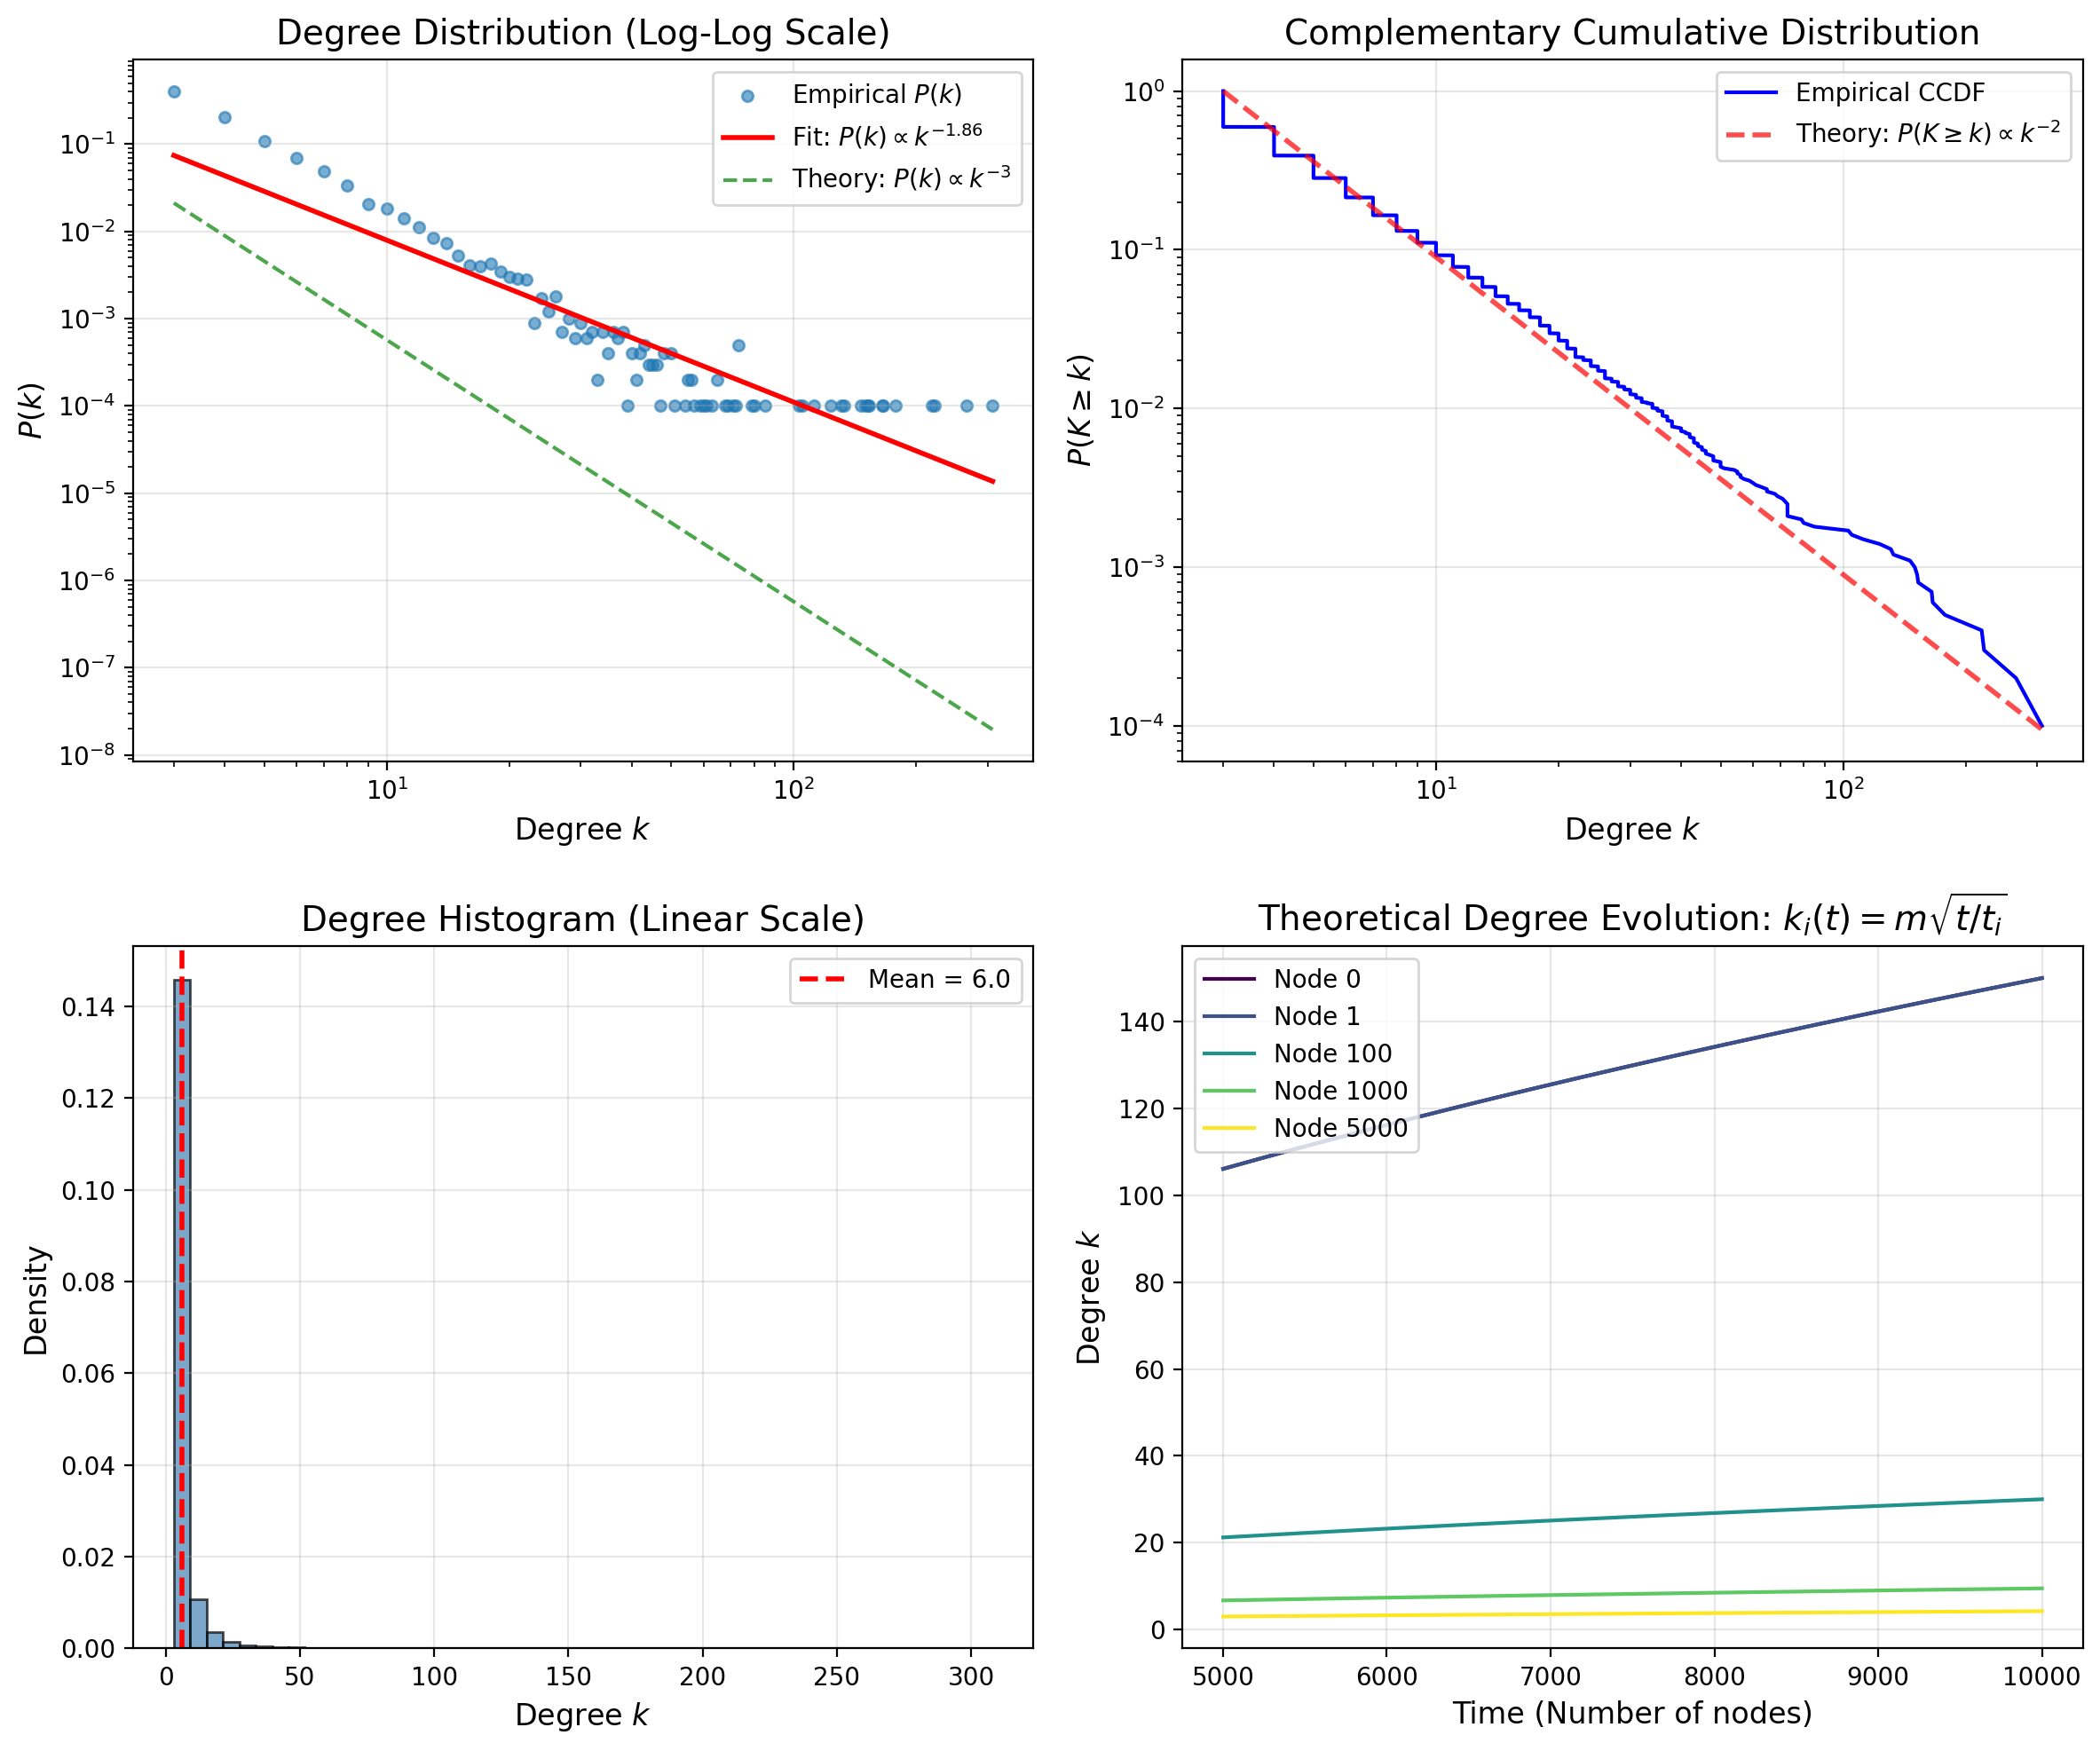

In [7]:
# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Log-log degree distribution
ax1 = axes[0, 0]
ax1.scatter(k_plot, p_plot, alpha=0.6, s=20, label='Empirical $P(k)$')

# Theoretical power law line
k_theory = np.logspace(np.log10(M), np.log10(max_degree), 100)
p_theory = (10**intercept) * k_theory**(-gamma_fit)
ax1.plot(k_theory, p_theory, 'r-', linewidth=2, 
         label=f'Fit: $P(k) \\propto k^{{-{gamma_fit:.2f}}}$')

# Reference line for gamma = 3
p_ref = (10**intercept) * k_theory**(-3)
ax1.plot(k_theory, p_ref, 'g--', linewidth=1.5, alpha=0.7,
         label=r'Theory: $P(k) \propto k^{-3}$')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Degree $k$', fontsize=12)
ax1.set_ylabel('$P(k)$', fontsize=12)
ax1.set_title('Degree Distribution (Log-Log Scale)', fontsize=14)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Cumulative distribution
ax2 = axes[0, 1]
# Compute complementary CDF: P(K >= k)
sorted_degrees = np.sort(degree_values)[::-1]
ccdf = np.arange(1, len(sorted_degrees) + 1) / len(sorted_degrees)
ax2.loglog(sorted_degrees, ccdf, 'b-', linewidth=1.5, label='Empirical CCDF')

# Theoretical CCDF for power law with gamma=3: P(K>=k) ~ k^(-(gamma-1)) = k^(-2)
k_ccdf = np.logspace(np.log10(M), np.log10(max_degree), 100)
ccdf_theory = (k_ccdf / M)**(-2)
ccdf_theory = ccdf_theory / ccdf_theory[0]  # Normalize
ax2.loglog(k_ccdf, ccdf_theory, 'r--', linewidth=2, alpha=0.7,
           label=r'Theory: $P(K \geq k) \propto k^{-2}$')

ax2.set_xlabel('Degree $k$', fontsize=12)
ax2.set_ylabel('$P(K \geq k)$', fontsize=12)
ax2.set_title('Complementary Cumulative Distribution', fontsize=14)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Plot 3: Linear histogram
ax3 = axes[1, 0]
ax3.hist(degree_values, bins=50, density=True, alpha=0.7, 
         color='steelblue', edgecolor='black')
ax3.axvline(mean_degree, color='red', linestyle='--', linewidth=2,
            label=f'Mean = {mean_degree:.1f}')
ax3.set_xlabel('Degree $k$', fontsize=12)
ax3.set_ylabel('Density', fontsize=12)
ax3.set_title('Degree Histogram (Linear Scale)', fontsize=14)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Network growth visualization
ax4 = axes[1, 1]
# Show how degree of early vs late nodes evolves
# Track degree evolution for a few nodes
tracked_nodes = [0, 1, 100, 1000, 5000]
colors = plt.cm.viridis(np.linspace(0, 1, len(tracked_nodes)))

# Theoretical degree evolution: k_i(t) = m * (t/t_i)^0.5
t_values = np.arange(max(tracked_nodes) + 1, N + 1)
for node, color in zip(tracked_nodes, colors):
    t_i = max(node, M + 1)  # Arrival time (or initial for first nodes)
    k_theory_evolution = M * np.sqrt(t_values / t_i)
    ax4.plot(t_values, k_theory_evolution, '-', color=color, linewidth=1.5,
             label=f'Node {node}')

ax4.set_xlabel('Time (Number of nodes)', fontsize=12)
ax4.set_ylabel('Degree $k$', fontsize=12)
ax4.set_title('Theoretical Degree Evolution: $k_i(t) = m\\sqrt{t/t_i}$', fontsize=14)
ax4.legend(loc='upper left')
ax4.grid(True, alpha=0.3)

plt.tight_layout()

# Save figure
plt.savefig('scale_free_network_barabasi_albert_analysis.png', dpi=150, bbox_inches='tight')
print("\nFigure saved to 'plot.png'")

plt.show()

## Analysis of Hub Nodes

A key characteristic of scale-free networks is the presence of hub nodes with exceptionally high connectivity. Let's examine the most connected nodes.

In [8]:
# Find top hub nodes
sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
print("Top 10 Hub Nodes:")
print("-" * 30)
for i, (node, degree) in enumerate(sorted_nodes[:10]):
    print(f"  {i+1}. Node {node}: degree = {degree}")

# Statistics about hubs
hub_threshold = np.percentile(degree_values, 99)  # Top 1%
hub_nodes = [n for n, d in degrees.items() if d >= hub_threshold]
print(f"\nHub Analysis (degree ≥ {hub_threshold:.0f}, top 1%):")
print(f"  Number of hubs: {len(hub_nodes)}")
hub_degrees = [degrees[n] for n in hub_nodes]
print(f"  Hub degree range: {min(hub_degrees)} - {max(hub_degrees)}")

Top 10 Hub Nodes:
------------------------------
  1. Node 2: degree = 308
  2. Node 4: degree = 266
  3. Node 3: degree = 222
  4. Node 8: degree = 219
  5. Node 1: degree = 178
  6. Node 6: degree = 166
  7. Node 40: degree = 165
  8. Node 10: degree = 153
  9. Node 18: degree = 152
  10. Node 20: degree = 150

Hub Analysis (degree ≥ 34, top 1%):
  Number of hubs: 100
  Hub degree range: 35 - 308


## Conclusion

The Barabási-Albert model successfully generates networks with:

1. **Power-law degree distribution** with exponent $\gamma \approx 3$, as predicted by theory
2. **Hub nodes** that emerge naturally from preferential attachment
3. **Scale-free property**: no characteristic degree scale; the distribution is self-similar across orders of magnitude

These properties match many real-world networks including the World Wide Web, citation networks, and some biological networks. The "rich get richer" mechanism of preferential attachment provides an elegant explanation for the ubiquity of scale-free structures in complex systems.

### Key Results

- Mean degree: $\langle k \rangle = 2m$
- Degree distribution: $P(k) \sim k^{-3}$
- Degree evolution: $k_i(t) \sim t^{1/2}$ (early nodes grow larger)

The model demonstrates that simple local rules (preferential attachment) can generate complex global structure (scale-free topology).